In [3]:
import km3io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import boost_histogram as bh
import glob, os
import operator
import functools
from scipy.optimize import curve_fit

# Data extraction
Data are extracted from `.root` files produced by `gSeaGen`. These files were produced as part of the v6 montecarlo production for ARCA 115 detector. Though these files were produced as part of the km3net simulation chain, the data extracted for this analysis does not contain any km3net related bias. 

These files contain the result of simulating neutrino interactions between $10^2$ and $10^8$ GeV for multiple neutrino flavors and for two interaction channels: charged current deep inelastic scattering, and neutral current deep inelastic scattering.

From each event, we extract the inelasticity parameter $y = (E_{\nu} - E_{l})/E_{\nu}$ and the energy of the interacting neutrino $E_{\nu}$. For this we use `km3io`.


In [4]:
def extract_data(gSeaGen_file):
    f = km3io.OfflineReader(gSeaGen_file)
    data = {}
    BY_IDX=km3io.definitions.w2list_gseagen.W2LIST_GSEAGEN_BY
    data['by']    = np.array(f.events.w2list[:,BY_IDX])
    data['e']     = np.array(f.events.mc_trks.E[:,0])
    data['loge']  = np.log10(data['e'])
    data['logby'] = np.log10(data['by'])
    return data

# Plotting functions


In [5]:
def plot_histogram(hist):
    plt.clf()
    # Compute the areas of each bin
    areas = functools.reduce(operator.mul, hist.axes.widths)
    # Compute the density
    density = hist.view() / hist.sum() / areas
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(*hist.axes.edges.T, density.T)
    fig.colorbar(mesh)
    plt.show()
    
    
def plot_2d_hist(h):    
    w,x,y = h.to_numpy()
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(x, y, w.T,norm=matplotlib.colors.LogNorm())
    ax.set_xlabel(h.axes[0].metadata)
    ax.set_ylabel(h.axes[1].metadata)
    fig.colorbar(mesh)
    return fig,ax

# Inelasticity parameter vs Energy

We are interested on the probability that a neutrino of energy $E_{\nu}$ produces a cascade of $10^5$ GeV. We will calculate it as the integral of the inelasticity pdf between two values, $y_1$ and $y_2$. The former corresponds to the value for which the cascade energy equals $9\cdot 10^4$ GeV, and the latter corresponds to the value for which the cascade's energy equals $1.1\cdot 10^5$ GeV

In [6]:
'''
Given an input energy corresponding to the energy of the interacting neutrino, this function returns a
range of the inelasticity parameter by which corresponds to a cascade energy between 90 and 110 TeV.
'''
def get_by_range(Energy):
    E_nu = Energy
    E_cascade = np.array([9e4,1.1e5])
    E_nu_prime = E_nu - E_cascade
    y = (E_nu - E_nu_prime)/E_nu
    return y

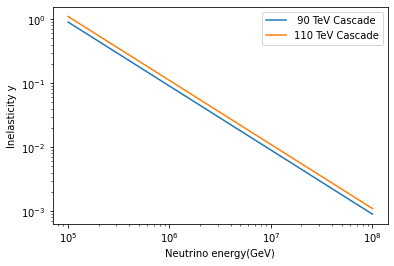

In [7]:
ymin=[]
ymax=[]
logE_min = 5.0
logE_max = 8.0
N_e = 100
step_e = (logE_max - logE_min)/N_e
logE_bins = np.arange(logE_min,logE_max+step_e,step_e)
E_bins_ = np.power(10,logE_bins)
for e in E_bins_:
    yrange = get_by_range(e)
    ymin.append(yrange[0])
    ymax.append(yrange[1])
    
plt.yscale("log")
plt.xscale("log")
plt.plot(E_bins_, ymin, label=' 90 TeV Cascade')
plt.plot(E_bins_, ymax, label='110 TeV Cascade')
plt.xlabel("Neutrino energy(GeV)")
plt.ylabel("Inelasticity y")
plt.legend()

# Functions related to boost-histograms. 

We define functions to calculate the integral of a 1D histogram between two bins or two values, functions to extract a slice from a 2D histogram and return it as a pdf (normalised so that it's integral equals 1), and other useful functions. 

In [8]:
'''
This function slices a 2D histogram and returns the 1d histogram corresponding to the chosen bin numer in the x axis
'''
def get_x_slice(hist2d, bin_number):
    minihist = hist2d[bin_number, :]
    return minihist

'''
This function receives a 2D boost histogram and returns a dictionary corresponing to a pdf for a given bin on the x axis.
The dictionary has the following keys:
    volumes: bin widths
    density: bin values
    centres: bin centres
'''
def get_x_pdf(hist2d, bin_number):
    h1d = hist2d[bin_number, :]
    d = {}
    volumes = np.prod(h1d.axes.widths, axis=0)
    density = h1d.view() / h1d.sum() / volumes
    d['density'] = density
    d['volumes'] = volumes
    d['centres'] = h1d.axes.centers[0]
    return d

'''
Given an array and a value, this function returns the index of the element in the array closest to the value.
'''
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

'''
h is a 1d histogram (dictionary) with the following keys:
    volumes: bin widths
    density: bin values
    centres: bin centres
this function returns the integral of the histogram between bin indices a and b.
'''
def integrate_bin_range(h,a,b):
    integral=0.
    if(len(h['volumes'][a:b])==len(h['density'][a:b])):
        for i, (c,w) in enumerate(zip(h['density'][a:b],h['volumes'][a:b])):
            integral = integral+c*w
    return integral

'''
h is a 1d histogram (dictionary) with the following keys:
    volumes: bin widths
    density: bin values
    centres: bin centres
this function returns the integral of the histogram in the x-axis range delimited by a and b.
'''
def integrate_x_range(h,a,b):
    integral=0.
    if(len(h['volumes'])==len(h['density'])):
        i = find_nearest_index(h['centres'], a)
        j = find_nearest_index(h['centres'], b)
        for i, (c,w) in enumerate(zip(h['density'][i:j],h['volumes'][i:j])):
            integral = integral+c*w
    return integral

# Definition of histogram ranges and histograms

The files we got from the ARCA 115 simulation go from $10^2$ GeV to $10^8$ GeV. We choose 100 bins in logE.

The inelasticity parameter varies between 0 and 1. We choose 300 bins in logy, where logy goes from -3.5 to 0.

In [9]:
# E
logE_min = 2.0
logE_max = 8.0
N_e = 100
step_e = (logE_max - logE_min)/N_e
logE_bins = np.arange(logE_min,logE_max+step_e,step_e)
E_bins = np.power(10,logE_bins)

# By
logBy_min = -3.5
logBy_max = 0
N_logBy = 400
step_logBy = (logBy_max - logBy_min)/N_logBy
logBy_bins = np.arange(logBy_min,logBy_max+step_logBy,step_logBy)
By_bins = np.power(10,logBy_bins)

e_vs_by = bh.Histogram(
        bh.axis.Variable(E_bins),
        bh.axis.Variable(By_bins)
    )

loge_vs_by = bh.Histogram(
            bh.axis.Variable(logE_bins),
            bh.axis.Variable(By_bins)
        )

loge_vs_logby = bh.Histogram(
                bh.axis.Variable(logE_bins),
                bh.axis.Variable(logBy_bins)
        )


In [10]:
nue_cc_files = glob.glob("/media/barracuda_ext/data/data/ARCA_115_v6/neutrinos/nue-cc/*.root")
numu_nc_files = glob.glob("/media/barracuda_ext/data/data/ARCA_115_v6/neutrinos/numu-nc/*.root")

In [11]:
for file in numu_nc_files:
    dict = extract_data(file)
    e_vs_by.fill(dict['e'],dict['by'])
    loge_vs_logby.fill(dict['loge'],dict['logby'])
    loge_vs_by.fill(dict['loge'],dict['by'])

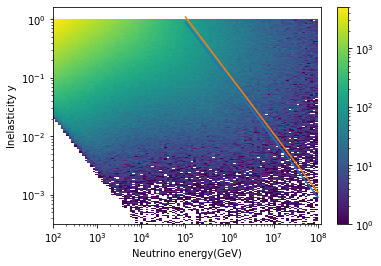

In [12]:
fig,ax=plot_2d_hist(e_vs_by)
ax.plot(E_bins_, ymin)
ax.plot(E_bins_, ymax)
plt.xlabel("Neutrino energy(GeV)")
plt.ylabel("Inelasticity y")
plt.yscale("log")
plt.xscale("log")

In [13]:
en=[]
pr=[]
idx = find_nearest_index(E_bins, 1e5)
for i, e in enumerate(E_bins[idx:-2]):
    pdf=get_x_pdf(e_vs_by,i+idx)
    y1,y2 = get_by_range(e)
    p = integrate_x_range(pdf,y1,y2)
    en.append(e)
    pr.append(p)

In [14]:
def p_100TeV(x, phi, gamma): 
    return phi * np.power((x), -gamma) 

In [15]:
a,b = curve_fit(p_100TeV, en[1:], pr[1:], maxfev=2000 )

/tmp/ipykernel_115984/2405627828.py:2: RuntimeWarning: overflow encountered in power
  return phi * np.power((x), -gamma)


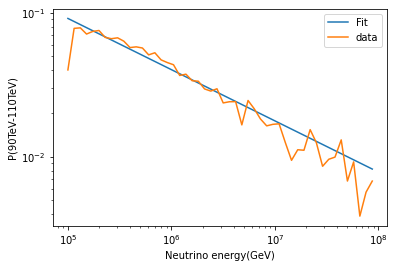

In [16]:
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Neutrino energy(GeV)")
plt.ylabel("P(90TeV-110TeV)")
plt.plot(en, p_100TeV(en, a[0], a[1]), label='Fit')
plt.plot(en,pr, label="data")
plt.legend()

In [17]:
print(a)

[5.46454189 0.35567507]
